## 手搓transformer的简单实现

In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken  # openai tokenizer
import torch
import torch.nn as nn

In [2]:
# Hyperparameters
batch_size = 4  # point to nums_of_squence
context_length = 16  # the length of the sequence,contain tokens
d_model = 64  # The vector size (token embeddings)

num_layers = 8  # transformer blocks
num_heads = 4  # heads of multi-head

learning_rate = 1e-3  
dropout = 0.1 # Dropout rate
max_iters = 500  # epochs
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  

TORCH_SEED = 1337 # random seed
torch.manual_seed(TORCH_SEED)

In [3]:
# download a sample txt file 
# https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

#### 文本处理:分词并且向量化
完整流程：
  文本 → 分词器 → token IDs → embedding层 → 向量表示\
  "hello" → tokenizer → [15339] → embedding → [0.1, -0.3, 0.8, ...]

#### Tokenizer

In [4]:
# Using TikToken to tokenize the source text
# 不同的编码方式对应不同的编码算法和分词词汇对应表
encoding = tiktoken.get_encoding("cl100k_base")  # encoding type：cl100k_base  openai开源的
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor

# item将单元素的tensor转化成标量
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

# 文本token数以及id最大值
print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [5]:
tokenized_text

tensor([26072,   220,    16,  ...,   315, 15676,    13], device='cuda:0')

In [6]:
# 测试词汇表的对应，也就是编码和解码
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


#### 划分数据集

In [7]:
# Split train and validation 
# 训练：验证  9：1
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [8]:
# Prepare data for training batch
data = train_data

idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))  # idx是每次截取的开始索引，保证每次都能截取完整的定义长度的句子

# decoder的作用是预测下一个字，所以这里的label就是比之前的x往后挪一位
# 4个句子 每个句子16个token
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])   # stack会将多个子张量沿着一个新的维度进行拼接
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [10]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)

# detach() 的作用是将张量从计算图中分离出来，创建一个新的张量，该张量与原张量共享数据但不再跟踪梯度
# 4*16
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0     1      2      3      4      5      6      7      8      9     10    11     12     13     14     15
0  27848  7720    323  12974  20124     11    279   6763   9164    649  1893   264   5647    315  20632    323
1   3118   459   6776    369   6763  15749    311  35883    872  19248   323  2686  10742  13750    627  67834
2  10209  6029     11   2587   4954    279   6425     11    323    312  2058  1113    279    907     11   6763
3  46551   279  94100    315  63120     12  57022   7278  66044    512  1271  9615  25555    304   6763     11


#### Embedding
ID--->VEC

In [9]:
# Define Token Embedding look-up table
# 建立词汇表：max_token_id + 1,d_model,每个token的维度是d_model
# dim：4，16，64
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
token_embedding_lookup_table.to("cuda:0")

print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [10]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data.to("cuda:0")) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data.to("cuda:0"))

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

#### Position Encoding

In [11]:
# Define Position Encoding look-up table
# 定义后面两个维度，前面batch维度复制batch次，16*64
# 奇数列用cos,偶数列用sin
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # e取ln，这是位置编码的分子项


position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)  # 偶数列，从0列开始
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)  # 奇数列，从1列开始
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


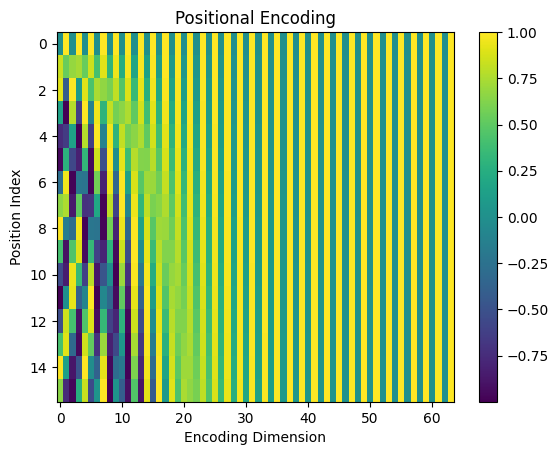

In [12]:
# Illustration Purpose Only
# 可视化位置编码
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [28]:
# Add positional encoding into the input embedding vector
# 完整的模型输入x=x+position
input_embedding_x = x_batch_embedding.to("cpu") + position_encoding_lookup_table.to("cpu")  # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding.to("cpu") + position_encoding_lookup_table.to("cpu")
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.399742,-0.206918,0.327990,0.748870,0.531874,0.751807,0.351938,0.610762,0.129977,-0.207580,...,-0.547752,2.515671,1.223743,1.833670,-0.404194,1.563555,0.591292,0.275255,1.670105,0.758279
1,1.407957,-0.561974,2.393893,0.377252,1.083746,0.138066,-0.334590,1.670161,0.329176,2.342795,...,0.873984,2.226714,0.794747,1.598629,0.884658,1.032520,1.353795,1.059697,1.172643,1.527427
2,0.482819,1.301215,0.653670,-0.846175,0.628521,1.126829,-0.102938,-0.636202,0.428573,0.553769,...,-0.934116,2.145729,-1.913517,0.552654,0.597746,2.673483,-1.969119,1.397835,-0.438208,0.437077
3,0.851059,0.379319,0.070685,0.910763,-1.117662,0.325378,0.947827,0.472564,0.516017,0.790074,...,0.072798,0.264451,0.070916,-1.744750,1.088080,0.002188,0.715526,-0.357311,1.604357,1.920290
4,-2.720048,-0.354717,0.272903,-0.906938,0.932237,-1.449321,-0.226828,-1.203768,2.488952,2.130765,...,0.533600,0.432145,-2.389682,0.913403,0.066965,1.655225,0.625080,0.236625,-0.692241,0.992275
5,-0.147775,0.718796,0.559903,-0.004127,-0.690035,-0.998508,0.331355,-1.222723,0.836060,-1.353497,...,-0.044886,-0.201054,-0.926252,1.322522,0.587324,1.108183,-1.652407,2.918813,0.942309,1.584330
6,0.038134,3.066611,-1.069607,0.424900,-1.142844,-2.948736,0.505219,-0.617680,1.280667,-0.168857,...,0.202646,1.051821,1.306703,1.517673,0.050767,1.044631,1.347860,0.678610,-0.477987,0.833080
7,-1.368717,2.010294,-1.177933,1.943613,0.931115,-2.610583,-0.812628,-1.958096,2.302625,0.242536,...,-2.336618,1.190780,-0.052987,3.281737,-0.415515,0.198294,-1.392472,2.863094,-0.392633,0.868254
8,3.896336,-0.053480,-1.065470,1.569054,-1.767442,-0.238040,-1.386770,-0.574759,0.118923,-1.069920,...,3.366446,0.203255,1.759607,2.526687,-0.652322,2.660683,0.966853,1.618786,1.664013,2.768385
9,1.811860,-2.118048,0.777184,0.642304,-0.407949,0.093468,-0.256171,-1.183092,0.421236,-2.164224,...,-0.543957,2.515664,1.226589,1.833666,-0.402059,1.563552,0.592893,0.275254,1.671305,0.758279


#### 输入x已经准备完毕，正式进入模型

In [29]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [30]:
# Define Query, Key, Value weight matrices
# Q，K，V
Wq = nn.Linear(d_model, d_model)  # 64*64
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)


# Multi-Head：在d_model上面进行维度的切分，并且维度转换成[batch，head，squence，dim of per-head]
Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]


print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

torch.Size([4, 16, 4, 16])


In [31]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

Q.shape

torch.Size([4, 4, 16, 16])

#### Self-Attention自注意力计算

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.945332,1.030662,0.337767,0.859085,1.102701,0.101895,1.015573,0.218932,0.460457,0.443775,0.727018,0.388041,1.089425,-0.507069,0.546713,0.311737
1,0.104477,0.687816,0.029710,0.444444,0.345905,-0.413628,-0.146516,-0.829756,-0.234578,-0.423368,-0.220005,0.035373,0.456192,-0.407098,0.238703,-0.097962
2,-0.616523,-0.414667,-0.256588,-0.461179,-0.455049,-0.913512,-0.347098,-0.580607,-0.295153,-0.621328,-0.371851,0.283000,-0.469571,-0.104985,-0.275101,-0.321073
3,0.441987,0.699722,0.068649,0.773966,0.897933,-0.259939,0.006163,-0.210088,-0.014368,0.031142,0.805621,-0.028645,-0.115070,-0.226875,0.278710,-0.229250
4,0.328848,0.293251,0.260467,0.329458,0.430013,-0.373063,-0.056358,0.106813,0.507612,-0.195985,0.089725,0.079781,0.237237,0.259634,0.522773,0.501700
5,0.687592,1.147419,-0.217308,0.829663,0.221912,0.594246,0.312856,-1.076963,-0.214361,0.261253,0.183409,0.170680,0.964169,-0.703455,0.499311,0.687672
6,-0.617375,0.391380,-0.715829,-0.668618,0.478204,-0.799876,0.014413,-0.832105,-1.113487,-0.817820,0.589651,-0.296200,0.091145,-0.407780,-0.464955,-0.764984
7,-1.482023,-0.567115,0.144619,-1.171687,-0.374756,-0.737784,-0.807560,-0.261786,-1.088448,-1.286951,0.133869,-0.623759,-0.658761,-0.199328,-0.774196,-0.838430
8,-0.224547,0.515266,-0.478027,0.463957,-0.932426,-0.235001,0.068161,-0.845048,-0.720815,-0.652047,-0.694349,-0.706499,-0.119893,-0.547267,-0.098622,-0.065425
9,0.860270,1.035518,-0.027161,0.627002,0.798576,-0.041596,0.980221,-0.112724,0.205110,0.307104,0.417819,0.228052,1.142123,-0.563927,0.490963,0.301996


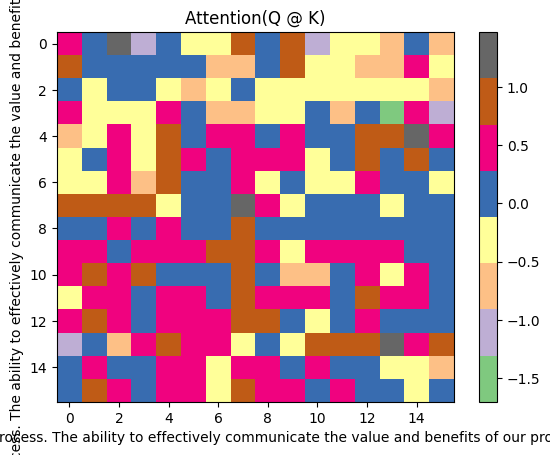

In [32]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") # plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))  # 第一句话的第一个头
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

#### 掩码Mask的应用
训练时保证每次训练计算注意力的时候只能计算自己和之前的词的注意力,看不到后面的词

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.945332,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,0.104477,0.687816,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.616523,-0.414667,-0.256588,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.441987,0.699722,0.068649,0.773966,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.328848,0.293251,0.260467,0.329458,0.430013,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.687592,1.147419,-0.217308,0.829663,0.221912,0.594246,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.617375,0.391380,-0.715829,-0.668618,0.478204,-0.799876,0.014413,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,-1.482023,-0.567115,0.144619,-1.171687,-0.374756,-0.737784,-0.807560,-0.261786,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.224547,0.515266,-0.478027,0.463957,-0.932426,-0.235001,0.068161,-0.845048,-0.720815,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.860270,1.035518,-0.027161,0.627002,0.798576,-0.041596,0.980221,-0.112724,0.205110,0.307104,-inf,-inf,-inf,-inf,-inf,-inf


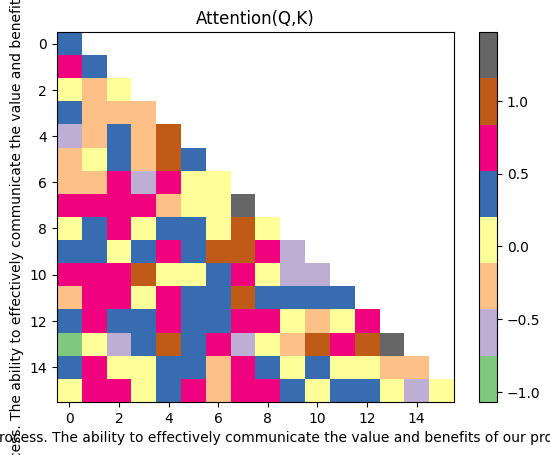

In [33]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] 

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")  # 第一个句子第一个头的维度信息
plt.title("Attention(Q,K)")  
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [34]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] 按列做softmax，也就是固定行，取每一列的元素
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.358165,0.641835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.273455,0.334619,0.391926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.228511,0.295693,0.157315,0.318481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.199760,0.192774,0.186557,0.199882,0.221026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.176068,0.278856,0.071234,0.202946,0.110519,0.160376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.088468,0.242595,0.080173,0.084049,0.264600,0.073710,0.166405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.048950,0.122205,0.248996,0.066762,0.148126,0.103032,0.096087,0.165842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.101717,0.213153,0.078942,0.202492,0.050115,0.100659,0.136306,0.054691,0.061925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.136220,0.162312,0.056084,0.107878,0.128070,0.055280,0.153580,0.051484,0.070747,0.078344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] 
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]

A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [36]:
# Concat the attention output
# 合并多个头的输出
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [37]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)  # 64*64
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.524786,-0.045412,-0.302636,-0.109781,-0.298154,-0.657590,0.454905,0.039457,0.100599,0.366610,...,0.142564,-0.272049,0.580245,-0.255839,-0.140195,0.372377,-0.804320,0.299504,-0.191014,0.197817
1,0.328462,-0.081245,-0.243604,-0.044755,-0.425665,-0.510309,0.439132,0.088448,0.145798,0.412693,...,0.205368,-0.364655,0.334732,-0.326960,-0.269596,0.069208,-0.427119,0.254583,-0.345342,0.106608
2,0.347237,-0.308549,-0.278262,0.143075,-0.598328,-0.465565,0.555204,0.059621,-0.021754,0.465287,...,0.219082,-0.574713,0.312764,-0.425730,-0.458381,0.095429,-0.493984,0.292389,-0.615254,-0.092998
3,0.214378,-0.009609,-0.334228,-0.062083,-0.414340,-0.467446,0.572733,-0.107637,-0.152299,0.337719,...,0.368783,-0.833862,0.379013,-0.390016,-0.237232,0.219289,-0.517244,0.272486,-0.470167,0.057640
4,0.513462,0.102085,-0.182719,0.201260,-0.191639,-0.669314,0.474926,0.059827,0.167270,0.627456,...,0.018919,-0.610420,0.527467,-0.308788,-0.398739,0.382149,-0.711166,-0.020554,-0.513523,0.079830
5,0.451143,0.137024,-0.261185,0.198996,-0.212392,-0.450561,0.423666,-0.171708,0.064819,0.398537,...,0.176583,-0.640445,0.454182,-0.227182,-0.402732,0.319025,-0.794134,0.099978,-0.551720,0.001758
6,0.410791,0.100262,-0.244119,0.129585,-0.270816,-0.153192,0.517192,-0.148949,-0.009580,0.485959,...,0.194268,-0.457695,0.293521,-0.030188,-0.549682,0.302182,-0.815327,0.143750,-0.432031,-0.102904
7,0.394486,0.005410,-0.142340,0.180002,-0.225875,-0.207860,0.391206,-0.195846,-0.119708,0.445471,...,0.154181,-0.590498,0.396737,-0.183086,-0.559407,0.360066,-0.804500,0.055978,-0.531569,-0.198866
8,0.125593,0.024126,-0.162391,-0.026378,-0.288635,-0.109155,0.400722,-0.237068,-0.259401,0.357576,...,0.417584,-0.508475,0.267492,-0.039675,-0.384989,0.324833,-0.683876,0.194893,-0.251340,-0.102251
9,0.208335,0.080869,-0.176592,0.011800,-0.164595,-0.132451,0.426680,-0.256176,-0.113023,0.458584,...,0.272968,-0.407845,0.282672,-0.056392,-0.429349,0.359373,-0.727980,0.148682,-0.304543,-0.048796


In [38]:
# Add residual connection
# resnet block
output = output + X

In [39]:
# Add Layer Normalization
# LN层
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [40]:
# Define Feed Forward Network
# FFN
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

In [41]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [42]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1)(output)   # 映射回词汇表 [squence,max_token_id]
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,1.409699,0.245098,-0.633188,-0.292446,0.106082,0.232312,0.979132,-0.221405,0.060104,-0.743163,...,1.484610,0.272874,0.405550,1.475055,-0.083211,1.000969,-0.420906,0.052378,0.264644,0.607351
1,1.440655,-0.536528,-0.090695,-0.029620,-0.052236,1.237659,0.354658,-0.958750,0.410798,-0.413689,...,1.583840,0.286640,0.218314,0.763217,-0.701107,0.596655,0.285854,-0.568380,0.082562,0.397593
2,0.836499,-0.723682,0.716075,-0.300420,0.869508,1.018316,0.050658,-0.941702,0.819134,0.443038,...,-0.088080,0.158850,0.292139,0.147552,-0.309566,0.022800,-0.162036,-0.807792,-0.557694,-0.113972
3,0.574310,0.696070,0.409154,0.541812,0.053311,0.028272,0.703703,-1.011438,0.645142,0.314646,...,-0.098448,-0.477272,0.645173,0.611340,-0.151558,-0.119020,0.424630,-1.203315,0.079174,-0.157795
4,0.553743,-1.039411,1.238509,-0.229147,1.314367,-0.524047,0.729960,0.324820,-0.282810,0.348075,...,0.651097,-0.502232,1.063996,1.158568,-0.467572,0.212655,-0.280956,-0.119609,-0.627591,0.217097
5,1.220075,-0.390354,0.430039,-0.070197,0.110793,-0.270395,0.127227,1.119783,0.094528,0.239805,...,-0.090995,-0.142138,0.287161,0.257604,0.158714,0.154682,-0.025355,-0.612309,-0.405875,0.140659
6,-0.103195,-0.225029,0.794591,0.409592,1.072821,0.313215,0.150452,0.429108,0.339818,-0.533139,...,0.232785,-0.806998,-0.527803,0.289968,-0.944499,-0.195647,0.823878,-0.226000,-0.802437,-0.608077
7,0.670175,-1.016791,0.922452,-0.952525,0.965421,-0.137254,0.986974,1.224745,-0.397448,-0.161191,...,0.064703,-0.313006,0.009647,0.459821,-0.201111,0.105873,0.200581,-0.488634,-0.079533,-0.422555
8,0.441486,0.701463,0.040283,0.768005,1.366154,-0.086027,-0.976730,0.184464,-0.310649,-0.842792,...,-0.705329,-0.873800,0.108527,-0.379570,0.167578,-0.328902,-0.287305,-0.185077,-0.048831,-0.717964
9,1.232939,0.849428,-0.175039,-0.203392,0.353158,0.182325,0.696097,-0.013733,-0.423645,-0.684317,...,1.345840,0.318454,0.427786,1.003299,0.129768,0.749831,-0.635154,-0.098991,0.161945,0.332711


In [43]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000035,0.000011,0.000004,0.000006,0.000009,0.000011,0.000022,0.000007,0.000009,0.000004,...,0.000037,0.000011,0.000013,0.000037,0.000008,0.000023,0.000006,0.000009,0.000011,0.000015
1,0.000035,0.000005,0.000008,0.000008,0.000008,0.000029,0.000012,0.000003,0.000013,0.000006,...,0.000041,0.000011,0.000010,0.000018,0.000004,0.000015,0.000011,0.000005,0.000009,0.000013
2,0.000019,0.000004,0.000017,0.000006,0.000020,0.000023,0.000009,0.000003,0.000019,0.000013,...,0.000008,0.000010,0.000011,0.000010,0.000006,0.000009,0.000007,0.000004,0.000005,0.000008
3,0.000015,0.000017,0.000013,0.000014,0.000009,0.000009,0.000017,0.000003,0.000016,0.000012,...,0.000008,0.000005,0.000016,0.000016,0.000007,0.000007,0.000013,0.000003,0.000009,0.000007
4,0.000015,0.000003,0.000029,0.000007,0.000031,0.000005,0.000018,0.000012,0.000006,0.000012,...,0.000016,0.000005,0.000024,0.000027,0.000005,0.000010,0.000006,0.000007,0.000005,0.000010
5,0.000029,0.000006,0.000013,0.000008,0.000009,0.000006,0.000010,0.000026,0.000009,0.000011,...,0.000008,0.000007,0.000011,0.000011,0.000010,0.000010,0.000008,0.000005,0.000006,0.000010
6,0.000008,0.000007,0.000019,0.000013,0.000025,0.000012,0.000010,0.000013,0.000012,0.000005,...,0.000011,0.000004,0.000005,0.000011,0.000003,0.000007,0.000019,0.000007,0.000004,0.000005
7,0.000017,0.000003,0.000021,0.000003,0.000022,0.000007,0.000023,0.000029,0.000006,0.000007,...,0.000009,0.000006,0.000009,0.000013,0.000007,0.000009,0.000010,0.000005,0.000008,0.000006
8,0.000013,0.000017,0.000009,0.000018,0.000033,0.000008,0.000003,0.000010,0.000006,0.000004,...,0.000004,0.000004,0.000009,0.000006,0.000010,0.000006,0.000006,0.000007,0.000008,0.000004
9,0.000029,0.000020,0.000007,0.000007,0.000012,0.000010,0.000017,0.000008,0.000006,0.000004,...,0.000032,0.000012,0.000013,0.000023,0.000010,0.000018,0.000004,0.000008,0.000010,0.000012


In [45]:
logits.shape

torch.Size([4, 16, 100070])

In [46]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item() # 第一句第一个token
encoding.decode([predicted_index])

'.WriteLine'

In [47]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'